<a href="https://colab.research.google.com/github/anphantt2406/Heritage-Health-Prize/blob/main/Model_withoutFeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/HHP_release3/new_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/HHP_release3/new_data


#Import Library

In [41]:
import glob
import math
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn import datasets, ensemble
from sklearn.datasets import make_regression

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#Define some needed function

Predictions are evaluated using root mean squared logarithmic error, referred to henceforth as RMSLE.

$$\varepsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(log(p_i+1) - log(a_i+1)^2 \right )}$$

Where:



*   $i$ is a patient's unique MemberID
*   $n$ is the total number of patients
*   $p_i$ is the prediction made for patient $i$
*   $a_i$ is the actual number of days spent in the hospital by patient $i$





In [18]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [19]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [20]:
def eval(model, X_test, y_test, name = None):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.clip(min=0)
    pred_y = pred_y.clip(max=15)
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,pred_y)
    from sklearn.metrics import mean_squared_log_error
    err = math.sqrt(mean_squared_log_error(y_test,pred_y))
    print("RMSLE of", name, ": %.4f" %rmsle)
    print("R2 value of", name, ": %.4f" %r2)
    print("Err value of", name, ": %.4f" %err)

In [21]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

#Prepare data for training and testing

In this notebook, we use Claims data in Year 1 for training and validation, Claims data in Year 2 for testing.

In [22]:
dataY1_df = pd.read_csv('fulldataY1.csv')
dataY2_df = pd.read_csv('fulldataY2.csv')

In [23]:
dataY1 = dataY1_df.drop("MemberID", axis = 1)
y = dataY1['TARGET']
X = dataY1.drop(['CLASS','TARGET'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [34]:
dataY2 = dataY2_df.drop("MemberID", axis = 1)
y_test = dataY2['TARGET']
X_test = dataY2.drop(['CLASS','TARGET'], axis = 1)
X_test = scaler.transform(X_test)

# Regression

## MODEL 1: Linear Regression

RMSLE of linear regression : 0.5291
R2 value of linear regression : 0.0439
Err value of linear regression : 0.5291


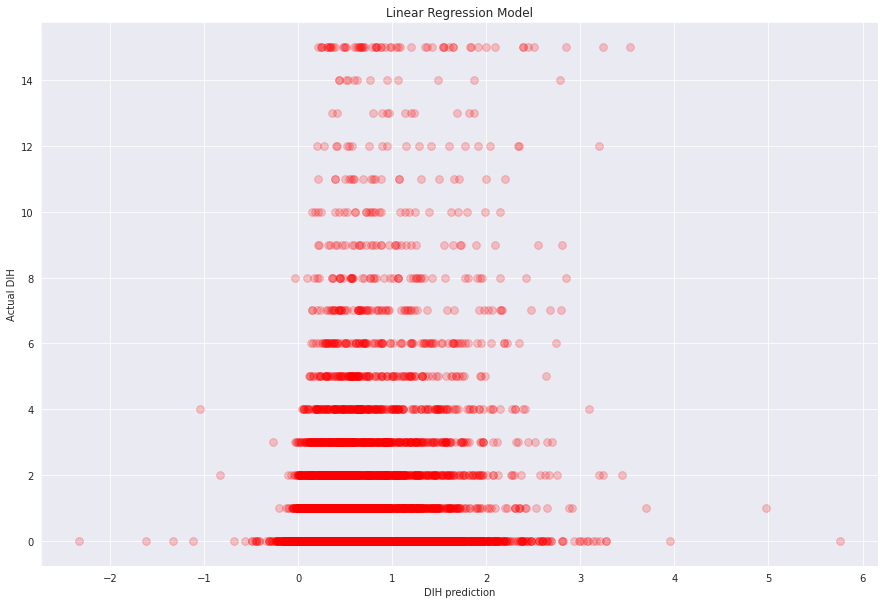

In [25]:
# Create linear regression object
model_1 = LinearRegression()
# Train the model using the training sets
model_1.fit(X_train, y_train)
# Predict on Test set
y_pred_1 = model_1.predict(X_valid)

# Evaluation on Validation set
eval(model_1, X_valid, y_valid,'linear regression')

plt.figure(figsize = (15,10))
plt.scatter(y_pred_1, y_valid, alpha=.2, s = 60, color='r') #alpha helps to show overlapping data
plt.xlabel('DIH prediction')
plt.ylabel('Actual DIH')
plt.title('Linear Regression Model')
plt.show()

## MODEL 2: Stochastic Gradient Descent

In [26]:
from sklearn.linear_model import SGDRegressor

model_2 = SGDRegressor(max_iter=3000, tol=1e-1)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_valid)
eval(model_2, X_valid, y_valid, 'Stochastic Gradient Descent')

RMSLE of Stochastic Gradient Descent : 0.5767
R2 value of Stochastic Gradient Descent : -0.0329
Err value of Stochastic Gradient Descent : 0.5767


In [27]:
model_2i = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False)
model_2i.fit(X_train, y_train)
eval(model_2i, X_valid, y_valid, 'Lasso regression')

RMSLE of Lasso regression : 0.5279
R2 value of Lasso regression : 0.0437
Err value of Lasso regression : 0.5279


##MODEL 3: Neural Network

In [28]:
#(i) Neural Network with default hyperparameters
model_3i = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred_3 = model_3i.predict(X_valid)
eval(model_3i, X_valid, y_valid, 'Neural Network_default')

RMSLE of Neural Network_default : 0.5923
R2 value of Neural Network_default : -0.0864
Err value of Neural Network_default : 0.5923


In [29]:
#(ii) random hyperparameter
model_3ii = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=7, learning_rate='adaptive',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3ii.fit(X_train, y_train)
eval(model_3ii, X_valid, y_valid , 'Neural Network_random')

Iteration 1, loss = 1.52774567
Iteration 2, loss = 1.29817743
Iteration 3, loss = 1.24759825
Iteration 4, loss = 1.22602533
Iteration 5, loss = 1.21178140
Iteration 6, loss = 1.20369818
Iteration 7, loss = 1.19756664
Iteration 8, loss = 1.19332755
Iteration 9, loss = 1.18921882
Iteration 10, loss = 1.18662374
Iteration 11, loss = 1.18440074
Iteration 12, loss = 1.18278245
Iteration 13, loss = 1.18071325
Iteration 14, loss = 1.17942381
Iteration 15, loss = 1.17815165
Iteration 16, loss = 1.17621498
Iteration 17, loss = 1.17583055
Iteration 18, loss = 1.17388944
Iteration 19, loss = 1.17324160
Iteration 20, loss = 1.17182150
Iteration 21, loss = 1.17097943
Iteration 22, loss = 1.17082738
Iteration 23, loss = 1.16822468
Iteration 24, loss = 1.16953784
Iteration 25, loss = 1.16833382
Iteration 26, loss = 1.16690534
Iteration 27, loss = 1.16622797
Iteration 28, loss = 1.16489519
Iteration 29, loss = 1.16341978
Iteration 30, loss = 1.16401666
Iteration 31, loss = 1.16372023
Iteration 32, los

**Hyperparameter Optimization using Grid Search**

In [30]:
#parameter_grid = {'hidden_layer_sizes': [i for i in range(1,10)],
#                  'activation': ['tanh', 'relu'],
#                  'solver': ['sgd','adam'],
#                  'learning_rate': ['constant'],
#                  'learning_rate_init': [0.001],
#                  'alpha': [0.0001],
#                  'max_iter': [1000],}

#rgr = GridSearchCV(MLPRegressor(), parameter_grid,
#                   cv = 5, verbose=True, pre_dispatch='2*n_jobs')
#rgr.fit(X_train, y_train)

#train_mse = mean_squared_error(y_train, rgr.predict(X_train))
#test_mse = mean_squared_error(y_valid, rgr.predict(X_valid))

#print(rgr.best_params_)
#print(rgr.best_score_)
#print("Train MSE:", np.round(train_mse,2))
#print("Test MSE:", np.round(test_mse,2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 64.3min finished


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'solver': 'adam'}
0.0645311627495467
Train MSE: 2.37
Test MSE: 2.42


In [31]:
from sklearn.neural_network import MLPRegressor

model_3 = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=2, learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3.fit(X_train, y_train)
eval(model_3, X_valid, y_valid, 'Neural Network_gridsearch')

Iteration 1, loss = 1.35019578
Iteration 2, loss = 1.24765622
Iteration 3, loss = 1.22846491
Iteration 4, loss = 1.21947959
Iteration 5, loss = 1.21385697
Iteration 6, loss = 1.20994316
Iteration 7, loss = 1.20707249
Iteration 8, loss = 1.20488671
Iteration 9, loss = 1.20389661
Iteration 10, loss = 1.20206677
Iteration 11, loss = 1.20143075
Iteration 12, loss = 1.20068639
Iteration 13, loss = 1.20003479
Iteration 14, loss = 1.19869798
Iteration 15, loss = 1.19882739
Iteration 16, loss = 1.19815503
Iteration 17, loss = 1.19738717
Iteration 18, loss = 1.19746084
Iteration 19, loss = 1.19658575
Iteration 20, loss = 1.19668868
Iteration 21, loss = 1.19622790
Iteration 22, loss = 1.19571597
Iteration 23, loss = 1.19528091
Iteration 24, loss = 1.19473481
Iteration 25, loss = 1.19454752
Iteration 26, loss = 1.19399994
Iteration 27, loss = 1.19401304
Iteration 28, loss = 1.19354226
Iteration 29, loss = 1.19342736
Iteration 30, loss = 1.19299958
Iteration 31, loss = 1.19293756
Iteration 32, los

## MODEL 4: XGBoost -  Gradient Boost Linear Regression Function

In [37]:
# Set XGBoost DataMatrix
dmatrix_train = xgboost.DMatrix(data=X_train,label=y_train)
dmatrix_test = xgboost.DMatrix(data=X_test,label=y_test)

[02:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:1.52253	train-rmse:1.60336	test-RMSLE:0.519597	train-RMSLE:0.528008
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.51554	train-rmse:1.59715	test-RMSLE:0.515956	train-RMSLE:0.523608
[2]	test-rmse:1.51078	train-rmse:1.59284	test-RMSLE:0.513683	train-RMSLE:0.520635
[3]	test-rmse:1.50745	train-rmse:1.58978	test-RMSLE:0.512178	train-RMSLE:0.518537
[4]	test-rmse:1.50507	train-rmse:1.58756	test-RMSLE:0.511114	train-RMSLE:0.516991
[5]	test-rmse:1.50333	train-rmse:1.58592	test-RMSLE:0.510311	train-RMSLE:0.515805
[6]	test-rmse:1.50202	train-rmse:1.58468	test-RMSLE:0.509668	train-RMSLE:0.514861
[7]	test-rmse:1.50103	train-rmse:1.58372	test-RMSLE:0.509128	train-RMSLE:0.514087
[8]	test-rmse:1.50024	train-rmse:1.58298	test-RMSLE:0.508658	train-RMSL

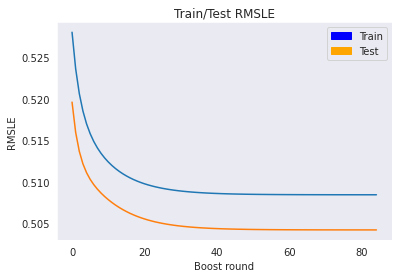

RMSLE Train set: 0.508452


In [38]:
# XGBoost
params = {'objective': 'reg:linear', 'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.5, 'learning_rate': 0.1, 'max_depth': 15, 'lambda': 10,
          'booster': 'gblinear'}
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])

# Final Results

In [43]:
reg = ensemble.GradientBoostingRegressor(n_estimators = 500,
          max_depth = 4,
          min_samples_split= 5,
          learning_rate = 0.01,
          loss = 'ls')
reg.fit(X_train, y_train)
eval(reg, X_valid, y_valid,'GradientBoostingRegressor')

RMSLE of GradientBoostingRegressor : 0.5300
R2 value of GradientBoostingRegressor : 0.0435
Err value of GradientBoostingRegressor : 0.5300


In [44]:
eval(model_1, X_test, y_test,'linear regression')
print('******')
eval(model_2, X_test, y_test, 'Stochastic Gradient Descent')
print('******')
eval(model_2i, X_test, y_test, 'Lasso regression')
print('******')
eval(model_3i, X_test, y_test, 'Neural Network_randomn')
print('******')
eval(model_3ii, X_test, y_test, 'Neural Network_random')
print('******')
eval(model_3, X_test, y_test, 'Neural Network_gridsearch')
print('******')
print('Gradient Boost Linear Regression _ RMSLE Test set:', xgb_results['test']['RMSLE'][-1]) 
print('******')
eval(reg, X_test, y_test,'GradientBoostingRegressor')

RMSLE of linear regression : 0.5320
R2 value of linear regression : 0.0312
Err value of linear regression : 0.5320
******
RMSLE of Stochastic Gradient Descent : 0.5671
R2 value of Stochastic Gradient Descent : -0.0439
Err value of Stochastic Gradient Descent : 0.5671
******
RMSLE of Lasso regression : 0.5311
R2 value of Lasso regression : 0.0322
Err value of Lasso regression : 0.5311
******
RMSLE of Neural Network_randomn : 0.6070
R2 value of Neural Network_randomn : -0.2133
Err value of Neural Network_randomn : 0.6070
******
RMSLE of Neural Network_random : 0.5432
R2 value of Neural Network_random : -0.0086
Err value of Neural Network_random : 0.5432
******
RMSLE of Neural Network_gridsearch : 0.5446
R2 value of Neural Network_gridsearch : 0.0259
Err value of Neural Network_gridsearch : 0.5446
******
Gradient Boost Linear Regression _ RMSLE Test set: 0.504223
******
RMSLE of GradientBoostingRegressor : 0.5294
R2 value of GradientBoostingRegressor : 0.0306
Err value of GradientBoosting

In [45]:
pred_y = xgb_model.predict(dmatrix_test)

submission = pd.DataFrame()
submission['MemberID'] = dataY2_df['MemberID']

pred_y = pred_y.clip(min=0)
pred_y = pred_y.clip(max=15)
# pred_y = pred_y.astype(int)

submission['DIH'] = pred_y
submission.groupby(['DIH']).size()

DIH
0.233970    1
0.238437    1
0.238465    1
0.238485    1
0.238581    1
           ..
1.733131    1
1.753657    1
1.755229    1
1.769118    1
1.786062    1
Length: 70787, dtype: int64

In [46]:
submission[submission['DIH']>=1]

,MemberID,DIH
16,20072,1.256995
24,32491,1.002549
25,33120,1.362876
29,42758,1.261419
30,47103,1.071007
...,...,...
71303,99827727,1.078878
71306,99829076,1.021540
71367,99896382,1.008147
71377,99916939,1.084600


In [47]:
dataY2_df[dataY2_df['MemberID']==	99932868]

,MemberID,AgeAtFirstClaim,Male,Female,Unknown,no_Claims,no_Providers,no_Specialties,no_PCG,no_Procedure,sum_PayDelay,sum_LOS,Specialty_Anesthesiology,Specialty_Diagnostic Imaging,Specialty_Emergency,Specialty_General Practice,Specialty_Internal,Specialty_Laboratory,Specialty_Obstetrics and Gynecology,Specialty_Other,Specialty_Pathology,Specialty_Pediatrics,Specialty_Rehabilitation,Specialty_Surgery,Place_Ambulance,Place_Home,Place_Independent Lab,Place_Inpatient Hospital,Place_Office,Place_Other,Place_Outpatient Hospital,Place_Urgent Care,DSFS_0- 1 month,DSFS_1- 2 months,DSFS_10-11 months,DSFS_11-12 months,DSFS_2- 3 months,DSFS_3- 4 months,DSFS_4- 5 months,DSFS_5- 6 months,...,PCG_PERVALV,PCG_PNCRDZ,PCG_PNEUM,PCG_PRGNCY,PCG_RENAL1,PCG_RENAL2,PCG_RENAL3,PCG_RESPR4,PCG_ROAMI,PCG_SEIZURE,PCG_SEPSIS,PCG_SKNAUT,PCG_STROKE,PCG_TRAUMA,PCG_UTI,Charlson_0,Charlson_1-2,Charlson_3-4,Charlson_5+,Procedure_ANES,Procedure_EM,Procedure_MED,Procedure_PL,Procedure_RAD,Procedure_SAS,Procedure_SCS,Procedure_SDS,Procedure_SEOA,Procedure_SGS,Procedure_SIS,Procedure_SMCD,Procedure_SMS,Procedure_SNS,Procedure_SO,Procedure_SRS,Procedure_SUS,DrugSum,LabSum,TARGET,CLASS
71389,99932868,45,0,0,1,42,13,6,9,7,1588,8,0,3,8,5,22,2,0,2,0,0,0,0,0,0,2,22,12,2,0,5,39,3,0,0,0,0,0,0,...,1,0,0,0,1,3,0,0,7,0,0,0,0,0,0,1,34,8,0,0,19,11,2,5,0,0,1,0,0,1,0,3,0,0,0,0,17,4,0,-1
